In [9]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
train_file_path = "../data/diabetes_prediction_dataset.csv"
df = pd.read_csv(train_file_path)

# fix some of the data issues
df["smoking_history"] = df["smoking_history"].replace("No Info", "unknown")
df["smoking_history"] = df["smoking_history"].replace("not current", "former")
df["smoking_history"] = df["smoking_history"].replace("ever", "former")

sh_hots = pd.get_dummies(df["smoking_history"], prefix="sh", dtype=int)
df = pd.concat([df, sh_hots], axis=1)
df = df.drop(["smoking_history"], axis=1)

df["gender"] = df["gender"].replace("Male", "male")
df["gender"] = df["gender"].replace("Female", "female")
df["gender"] = df["gender"].replace("Other", "other")

sh_hots = pd.get_dummies(df["gender"], prefix="gender", dtype=int)
df = pd.concat([df, sh_hots], axis=1)
df = df.drop(["gender"], axis=1)

df["age"] = (df["age"] - df["age"].mean()) / df["age"].std()
df["bmi"] = (df["bmi"] - df["bmi"].mean()) / df["bmi"].std()
df["HbA1c_level"] = (df["HbA1c_level"] - df["HbA1c_level"].mean()) / df["HbA1c_level"].std()
df["blood_glucose_level"] = (df["blood_glucose_level"] - df["blood_glucose_level"].mean()) / df["blood_glucose_level"].std()

y = df["diabetes"].to_numpy().reshape(-1, 1)
X = df.drop(["diabetes"], axis=1).to_numpy()

In [3]:
# # randomly split the data into training, cross validation and test sets
random_state = 42

X_train, X_blind, y_train, y_blind = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

X_test, X_cv, y_test, y_cv = train_test_split(
    X_blind, y_blind, test_size=0.5, random_state=random_state)

print(f'tf.__version__={tf.__version__}')
print(f'X.shape={X.shape}')
print(f'X_train.shape={X_train.shape}')
print(f'X_cv.shape={X_cv.shape}')
print(f'X_test.shape={X_test.shape}')
print(f'y.shape={y.shape}')
print(f'y max={np.max(y)} y min={np.min(y)}')

df.head()

tf.__version__=2.16.1
X.shape=(100000, 13)
X_train.shape=(80000, 13)
X_cv.shape=(10000, 13)
X_test.shape=(10000, 13)
y.shape=(100000, 1)
y max=1 y min=0


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,sh_current,sh_former,sh_never,sh_unknown,gender_female,gender_male,gender_other
0,1.692695,0,1,-0.321054,1.001701,0.047704,0,0,0,1,0,1,0,0
1,0.538004,0,0,-0.000116,1.001701,-1.426203,0,0,0,0,1,1,0,0
2,-0.616688,0,0,-0.000116,0.161107,0.489876,0,0,0,1,0,0,1,0
3,-0.261398,0,0,-0.583229,-0.492688,0.416181,0,1,0,0,0,1,0,0
4,1.515050,1,1,-1.081965,-0.679486,0.416181,0,1,0,0,0,0,1,0


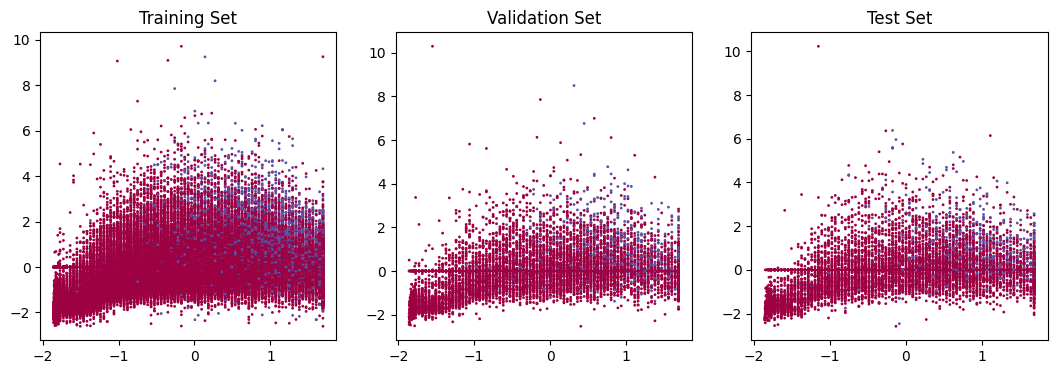

In [4]:
plt.figure(figsize=(13, 4))

plt.subplot(1, 3, 1)
plt.scatter(X_train[:, 0], X_train[:, 3], c=y_train, s=1, cmap=plt.cm.Spectral)
plt.title('Training Set')

plt.subplot(1, 3, 2)
plt.scatter(X_cv[:, 0], X_cv[:, 3], c=y_cv, s=1, cmap=plt.cm.Spectral)
plt.title('Validation Set')

plt.subplot(1, 3, 3)
plt.scatter(X_test[:, 0], X_test[:, 3], c=y_test, s=1, cmap=plt.cm.Spectral)
plt.title('Test Set')

plt.show()

In [5]:
# setup the layers
regfac = 0.00005
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=l1(regfac)),
    tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=l1(regfac)),
    tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=l1(regfac)),
    tf.keras.layers.Dense(30, activation='relu', kernel_regularizer=l1(regfac)),
    tf.keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=l1(regfac))
])

epochs = 10
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

2024-04-29 05:06:54.751058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 05:06:54.755015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 05:06:54.755047: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 05:06:54.764131: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 05:06:54.764165: I external/local_xla/xla/stream_executor

In [6]:
%%time
history = model.fit(X_train, y_train, epochs=epochs, verbose=1, validation_data=(X_cv, y_cv))
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10


I0000 00:00:1714367216.661597   55032 service.cc:145] XLA service 0x7f05e4019c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714367216.661638   55032 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-29 05:06:56.687382: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-29 05:06:56.831141: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  89/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7135 - loss: 0.5314    

I0000 00:00:1714367218.023299   55032 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9397 - loss: 0.1760 - val_accuracy: 0.9709 - val_loss: 0.1039
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9695 - loss: 0.1043 - val_accuracy: 0.9716 - val_loss: 0.0954
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9694 - loss: 0.0999 - val_accuracy: 0.9728 - val_loss: 0.0927
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9708 - loss: 0.0955 - val_accuracy: 0.9726 - val_loss: 0.0890
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9709 - loss: 0.0928 - val_accuracy: 0.9731 - val_loss: 0.0869
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9719 - loss: 0.0891 - val_accuracy: 0.9734 - val_loss: 0.0864
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9721 - loss: 0.0878 - val_accuracy: 0.9729 - val_loss: 0.0871
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.9719 - loss: 0.0886 - val_acc

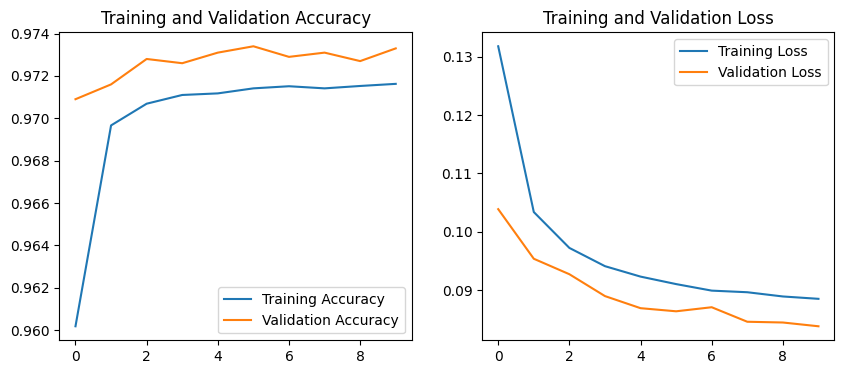

test acc: 97.07% test loss: 0.091


In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print(f'test acc: {test_acc*100:0.2f}% test loss: {test_loss:0.3f}')

In [13]:
Z = np.argmax(model.predict(X_test), axis=1)

 18/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [16]:
FP = np.sum(np.logical_and(Z == 1, y_test.flatten() == 0))
FN = np.sum(np.logical_and(Z == 0, y_test.flatten() == 1))
TP = np.sum(np.logical_and(Z == 1, y_test.flatten() == 1))
TN = np.sum(np.logical_and(Z == 0, y_test.flatten() == 0))
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
print(f'precision={precision:0.3f} recall={recall:0.3f} f1={f1:0.3f}')

precision=1.000 recall=0.653 f1=0.790
